# fMRI Machine Learning using Bayesian Regularised Regression

The notebook below demonstrates a Machine learning approach to the analysis of the  structural MRI data. The data provided by the Autism Brain Imaging Data Exchange II (ABIBEII) study from Di Martino et al (2017).The study is international collabortion towards the study of Austism. Specifically, by genereating large samples of structural MRI data from multiple international reseacrh sites. The data analysed below is the lightly preprocessed data from  Bethlehem (2020). Here having been downloaded and stored into the associated Datasets github of this notebooks author (see, the repositories https://github.com/HPCurtis?tab=repositories.

The ABIBE dataset here contains a range of features that can be categorised broadly into three seperate categories. The first of which are simple identifiers (site, subject). The second are phenotype features (age, sex, diagnosis of autism present). Thirdly, the rest of the data set are 4 set of structural brain features (suface Area, volume, cortical thickness and gyrification)(tagged as fsArea, fsVol, fsCT and fsLGI in the dataset). Each of the four features containing 360 variables resulting in 1440 feaautres in total. Each of the these360 features represents a region of interest specified in the Human Connectome Project Glasser et al. (2016).

In [11]:
# Import neccesary python packages.
from cmdstanpy import CmdStanModel, write_stan_json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import arviz as az

## Define useful functions for the analysis below 

In [12]:
# Define pythonised Prediction mean squared error function for Bayesian regularized regression models.
# Based on R function from https://github.com/sara-vanerp/bayesreg/blob/master/R/pmse_lm.R
def pmse(object, ytest):
    draws = object.draws_pd(vars = 'y_test')
    draws = draws.T
    postmeans = draws[0].mean()
    pmse = np.mean((postmeans-ytest)**2)
    return pmse, draws[0] 

${ \frac{1}{N} \Sigma^N_{i=1} (y^{gen}_i - y_i)^2 }$

# Data cleaning

In [13]:
# Read ABIDEII dataset from github using pandas.
d =  pd.read_csv('https://raw.githubusercontent.com/HPCurtis/Datasets/main/abide2.csv')

In [14]:
# View the top three rows of dataset.
d.head(3)

,Unnamed: 0,site,subject,age,sex,group,age_resid,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
0,0,ABIDEII-KKI_1,29293,8.893151,2.0,1.0,13.642852,2750.0,306.0,354.0,...,3.362,2.827,2.777,2.526,3.202,3.024,3.354,2.629,2.699,3.179
1,1,ABIDEII-OHSU_1,28997,12.000000,2.0,1.0,16.081732,2836.0,186.0,354.0,...,2.809,3.539,2.944,2.769,3.530,3.079,3.282,2.670,2.746,3.324
2,2,ABIDEII-GU_1,28845,8.390000,1.0,2.0,12.866264,3394.0,223.0,373.0,...,2.435,3.321,2.799,2.388,3.148,3.125,3.116,2.891,2.940,3.232


In [15]:
# Extract 
y = d.age
features = d.filter(like='fs')

In [16]:
# Split data into training and test sets using sklearn train_test_split.
X_train, X_test, y_train, y_test = train_test_split(features, y, train_size = 0.8)

# Standardise the y_test data so they are on the same scale so predciton error is on the 
# equivalent scale
y_test = scale(np.asarray(y_test))

# Create python dictionary to passs the data of the anlaysis to
# the prerequisite .JSON file below
dataDic = {'N_train': len(X_train),
           'N_test': len(X_test),
           'p': np.shape(X_train)[1],
           'X_train': X_train,
           'X_test': X_test,
           'y_train': y_train
           }

# Write JSON file for data to be passed to Stan.
write_stan_json(path = 'RegRegABIDE.json' , data = dataDic)

# Bayesian LASSO regression

In [29]:
# Compile stan model into C++.
modelL = CmdStanModel(stan_file = 'RegLasso.stan', cpp_options={'STAN_THREADS':'true'})

14:54:54 - cmdstanpy - INFO - compiling stan file /home/harrison/Desktop/gitHubRepos/ML_port/fMRI/RegLasso.stan to exe file /home/harrison/Desktop/gitHubRepos/ML_port/fMRI/RegLasso
14:55:14 - cmdstanpy - INFO - compiled model executable: /home/harrison/Desktop/gitHubRepos/ML_port/fMRI/RegLasso
14:55:14 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
14:55:14 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/harrison/Desktop/gitHubRepos/ML_port/fMRI/RegLasso.hpp /home/harrison/Desktop/gitHubRepos/ML_port/fMRI/RegLasso.stan
Warning in '/home/harrison/Desktop/gitHubRepos/ML_port/fMRI/RegLasso.stan', line 50, column 1: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
/home/harrison/anaconda3/envs/ML_env/bi

In [32]:
# Use varaitional infernce to calculate init values to speed up HMC sampling below. 
vbfitL = modelL.variational(data ='RegRegABIDE.json', require_converged = False, seed = 1, grad_samples = 10)
vbL_vars = vbfitL.stan_variables()

14:58:42 - cmdstanpy - INFO - Chain [1] start processing
15:00:27 - cmdstanpy - INFO - Chain [1] done processing
15:00:27 - cmdstanpy - WARNING - The algorithm may not have converged.
Proceeding because require_converged is set to False


In [33]:
# fit the Stan model to the data.
fitL = modelL.sample(data ='RegRegABIDE.json', chains = 4, inits = vbL_vars, iter_sampling = 1000, iter_warmup = 500);

15:00:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:15:33 - cmdstanpy - INFO - CmdStan done processing.
15:15:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: double_exponential_lpdf: Scale parameter is 0, but must be positive finite! (in '/home/harrison/Desktop/gitHubRepos/ML_port/fMRI/RegLasso.stan', line 40, column 1 to column 44)
	Exception: double_exponential_lpdf: Scale parameter is -nan, but must be positive finite! (in '/home/harrison/Desktop/gitHubRepos/ML_port/fMRI/RegLasso.stan', line 40, column 1 to column 44)
	Exception: double_exponential_lpdf: Scale parameter is 0, but must be positive finite! (in '/home/harrison/Desktop/gitHubRepos/ML_port/fMRI/RegLasso.stan', line 40, column 1 to column 44)
	Exception: double_exponential_lpdf: Scale parameter is -nan, but must be positive finite! (in '/home/harrison/Desktop/gitHubRepos/ML_port/fMRI/RegLasso.stan', line 40, column 1 to column 44)
Consider re-running with show_console=True if the above output is unclear!


In [51]:
summL = az.summary(fitL)
#summL.to_csv('LassoSummary.csv')
LassoDrawsDf = fitL.draws_pd()
LassoDrawsDf.to_csv('LassoSamples.csv')

In [37]:
summL

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.000,0.016,-0.029,0.031,0.000,0.000,4413.0,2594.0,1.0
sigma2,0.216,0.015,0.189,0.243,0.000,0.000,1490.0,2373.0,1.0
beta[0],-0.002,0.013,-0.031,0.021,0.000,0.000,4027.0,2309.0,1.0
beta[1],-0.002,0.014,-0.031,0.025,0.000,0.000,3534.0,1758.0,1.0
beta[2],0.001,0.014,-0.026,0.026,0.000,0.000,3072.0,2047.0,1.0
...,...,...,...,...,...,...,...,...,...
y_test[196],2.217,0.546,1.192,3.233,0.009,0.006,3910.0,3822.0,1.0
y_test[197],-0.429,0.565,-1.554,0.586,0.009,0.007,3643.0,3732.0,1.0
y_test[198],-1.056,0.532,-2.102,-0.104,0.009,0.006,3636.0,3749.0,1.0
y_test[199],-0.148,0.550,-1.216,0.827,0.009,0.006,3622.0,3811.0,1.0


In [43]:
LassoDrawsDf;

In [45]:
# Compute the point estimate of the prediction error
mseL, drawsL = pmse(fitL, y_test)

/home/harrison/anaconda3/envs/ML_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/harrison/anaconda3/envs/ML_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/harrison/anaconda3/envs/ML_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/harrison/anaconda3/envs/ML_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

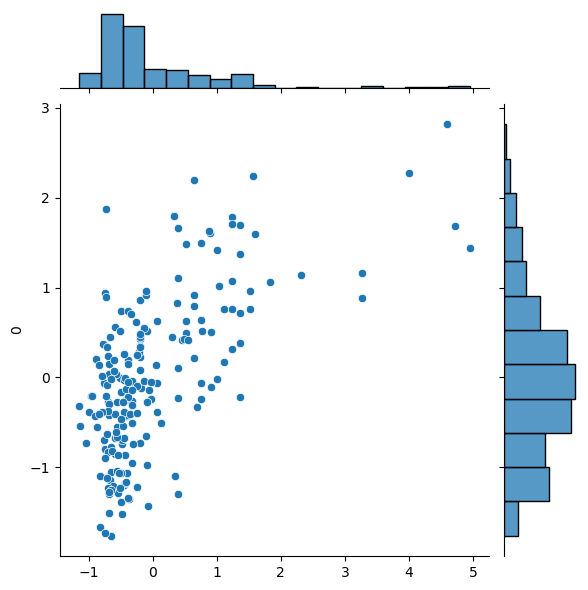

In [46]:
sns.jointplot(x = y_test, y = drawsL );

# Bayesian Ridge Regression analysis

In [17]:
# Compile stan model into C++.
modelR = CmdStanModel(stan_file = 'RegReg.stan', cpp_options={'STAN_THREADS':'true'})

14:44:58 - cmdstanpy - INFO - compiling stan file /home/harrison/Desktop/gitHubRepos/ML_port/fMRI/RegReg.stan to exe file /home/harrison/Desktop/gitHubRepos/ML_port/fMRI/RegReg
14:45:17 - cmdstanpy - INFO - compiled model executable: /home/harrison/Desktop/gitHubRepos/ML_port/fMRI/RegReg
14:45:17 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
14:45:17 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/harrison/Desktop/gitHubRepos/ML_port/fMRI/RegReg.hpp /home/harrison/Desktop/gitHubRepos/ML_port/fMRI/RegReg.stan
Warning in '/home/harrison/Desktop/gitHubRepos/ML_port/fMRI/RegReg.stan', line 54, column 1: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
/home/harrison/anaconda3/envs/ML_env/bin/x86_64-con

In [38]:
# Use varaitional infernce to calculate init values to speed up HMC sampling below. 
vbfitR = modelR.variational(data ='RegRegABIDE.json', require_converged = False, seed = 1, grad_samples = 10)
vbR_vars = vbfitR.stan_variables()

15:18:40 - cmdstanpy - INFO - Chain [1] start processing
15:20:32 - cmdstanpy - INFO - Chain [1] done processing
15:20:32 - cmdstanpy - WARNING - The algorithm may not have converged.
Proceeding because require_converged is set to False


In [53]:
# fit the Stan model to the data.
fitR = modelR.sample(data ='RegRegABIDE.json', chains = 4, inits = vbR_vars, iter_sampling = 1000, iter_warmup = 500);

15:45:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:47:52 - cmdstanpy - INFO - CmdStan done processing.
15:47:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/harrison/Desktop/gitHubRepos/ML_port/fMRI/RegReg.stan', line 44, column 1 to column 30)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/harrison/Desktop/gitHubRepos/ML_port/fMRI/RegReg.stan', line 44, column 1 to column 30)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/harrison/Desktop/gitHubRepos/ML_port/fMRI/RegReg.stan', line 44, column 1 to column 30)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/harrison/Desktop/gitHubRepos/ML_port/fMRI/RegReg.stan', line 44, column 1 to column 30)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/harrison/Desktop/gitHubRepos/ML_port/fMRI/RegReg.stan', line 44, column 1 to column 30)
	Exception: normal_lpdf: Scale parameter

In [52]:
summR = az.summary(fitR)
summR.to_csv('RidgeSummary.csv')
RidgeDrawsDf = fitR.draws_pd()
RidgeDrawsDf.to_csv('RidgeSamples.csv')

In [40]:
# Compute the point estimate of the prediction error
mseR, drawsR = pmse(fitR, y_test)

 ## Plot Predictions against test set

/home/harrison/anaconda3/envs/ML_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/harrison/anaconda3/envs/ML_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/harrison/anaconda3/envs/ML_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/harrison/anaconda3/envs/ML_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

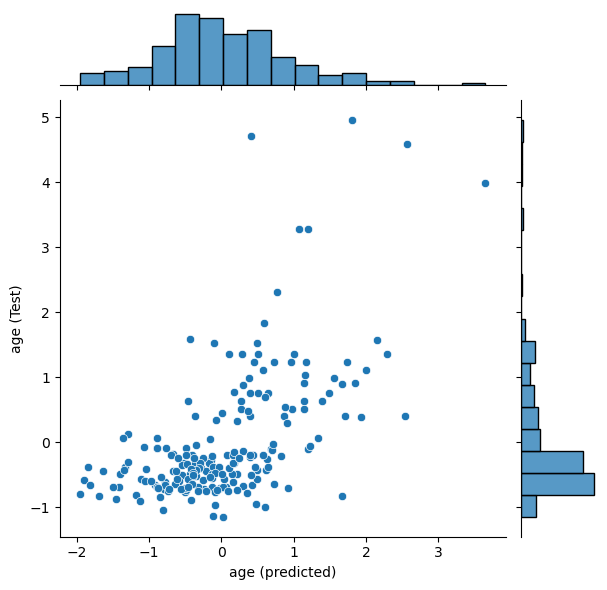

In [56]:
sns.jointplot(x = drawsR, y = y_test ).set_axis_labels("age (predicted)", "age (Test)");

In [47]:
[mseL, mseR]

[1.0000134564182834, 1.0012122345750354]

# References 

Bethlehem, R. A., Seidlitz, J., Romero-Garcia, R., Trakoshis, S., Dumas, G., & Lombardo, M. V. (2020). A normative modelling approach reveals age-atypical cortical thickness in a subgroup of males with autism spectrum disorder. Communications biology, 3(1), 486.

Di Martino, A., O’connor, D., Chen, B., Alaerts, K., Anderson, J. S., Assaf, M., ... & Milham, M. P. (2017). Enhancing studies of the connectome in autism using the autism brain imaging data exchange II. Scientific data, 4(1), 1-15.

Glasser, M. F., Coalson, T. S., Robinson, E. C., Hacker, C. D., Harwell, J., Yacoub, E., ... & Van Essen, D. C. (2016). A multi-modal parcellation of human cerebral cortex. Nature, 536(7615), 171-178.